# Predict Apple Stock using LSTM

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1.ETL

In [2]:
df = pd.read_csv('../data/appl_1980_2014.csv',index_col=0,parse_dates=True)
df.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2014-07-08,96.27,96.80,93.92,95.35,65130000,95.35
2014-07-07,94.14,95.99,94.10,95.97,56305400,95.97
2014-07-03,93.67,94.10,93.20,94.03,22891800,94.03
2014-07-02,93.87,94.06,93.09,93.48,28420900,93.48
2014-07-01,93.52,94.07,93.13,93.52,38170200,93.52


In [3]:
df = df.drop(columns=['Open', 'High','Low','Adj Close','Volume'])
df.head()

,Close
Date,
2014-07-08,95.35
2014-07-07,95.97
2014-07-03,94.03
2014-07-02,93.48
2014-07-01,93.52


In [4]:
df.shape

(8465, 1)

## 2.EDA

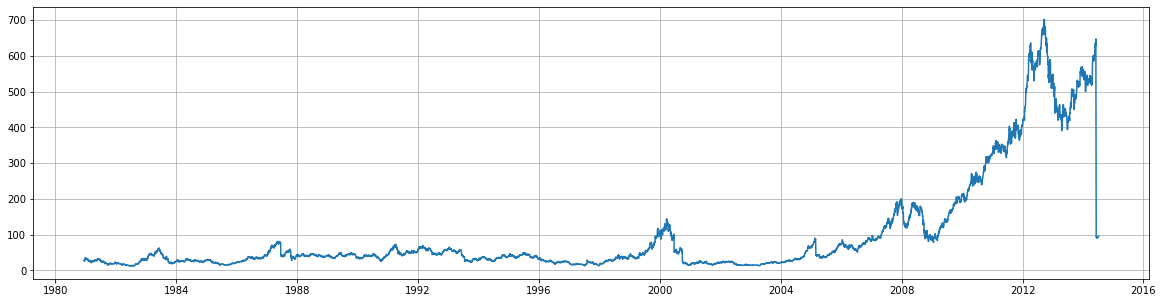

In [5]:
plt.figure(figsize=(20,5))
plt.plot(df['Close'])
plt.grid()

## 3. Feature Extraction

In [6]:
y = df['Close'].values.astype('float') #.values is basically getting numpy array of pandas
y.shape

(8465,)

In [7]:
#test size
test_size = 200

train_set = y[:-test_size]
test_set = y[-test_size:]

In [8]:
train_set.shape

(8265,)

## 4. Prepocessing

In anything, for neural network, it's better to normalize, so to reach convergence faster.... 

Two ways are:

1.Standardizing - normalize aorund the mean $\displaystyle\frac{x_i-\mu}{\sigma}$

2.MinMax - $\displaystyle\frac{x_i-x_\text{min}}{x_\text{max}-x_\text{min}}$

In signal, we cannot the trust the mean, so MinMax is better

In [9]:
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler(feature_range=(-1,1)) #by defauly 0,1
#for signal, -1 to 1 is good way to normalize

In [10]:
#to prevent data lekage, you only scale the train set independently of test set
#scalar.fit_transform((m,n))
train_minmax = scalar.fit_transform(train_set.reshape(-1,1))

In [11]:
train_minmax.min(), train_minmax.max(), train_minmax.mean()

(-1.0, 0.9999999999999998, -0.7415862749994903)

In [12]:
# train_minmax = torch.FloatTensor(train_minmax.reshape(-1)) #or
train_minmax = torch.FloatTensor(train_minmax).view(-1)
train_minmax.size()

torch.Size([8265])

## 5. Create our batch creator

In [13]:
window_size = 30

def input_data(seq, window_size,label_size=1):
    out = []
    total_length = len(seq)
    for i in range(total_length-window_size): #if not, we will go out of bound
        window = seq[i:i+window_size]
        label = seq[i+window_size:i+window_size+label_size]
        out.append((window,label))
    return out

#question: if my window is 200, label size is 1, my seq is 8065
#        : then what is the shape of out

In [14]:
train_data = input_data(train_minmax,window_size)

len(train_data) 

8235

In [15]:
train_data[0] #sample should be simply(200,1)

(tensor([-0.7559, -0.7541, -0.7597, -0.7613, -0.7612, -0.7629, -0.7656, -0.7688,
         -0.7703, -0.7706, -0.7690, -0.7687, -0.7660, -0.7651, -0.7654, -0.7650,
         -0.7677, -0.7648, -0.7602, -0.7591, -0.7607,  0.8364,  0.8416,  0.8342,
          0.8132,  0.7874,  0.8000,  0.8069,  0.7740,  0.7787]),
 tensor([0.7454]))

## 6. Define the model

In [31]:
class LSTM(nn.Module):
    #why out_size = 1, because later on, we will label_size =1
    def __init__(self,input_size = 1 ,hidden_size = 100, out_size = 1):
        super().__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size,hidden_size)
        self.linear = nn.Linear(hidden_size,out_size) #taking the last hidden state

        #optional 
        #h0, c0
        #(D*num layer, N, Hin)
        self.hidden = (torch.zeros(1, 1, hidden_size).to(device),
                       torch.zeros(1, 1, hidden_size).to(device))

    def forward(self, seq):
        #seq shape : 30 
        seq = seq.reshape(len(seq),1,-1)
        #seq shape : (30, 1, 1)
        out, (_,_) = self.lstm(seq, self.hidden) #you don't need self.hidden
        #out shape : (L, N, Hout * D) ==> (30, 1, 100)
        #get the last hidden state
        out = out[-1,:,:] #(B, Hout)
        #out shape : (1,100) 
        out = self.linear(out)
        #out shape : (1, 1)
        return out

In [32]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## 7. Training!!

In [33]:
torch.manual_seed(9999)

model = LSTM().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
torch.set_printoptions(sci_mode=False)

In [34]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model) #why 400?, why 40000????

   400
 40000
   400
   400
   100
     1
______
 41301


In [35]:
epochs = 5
future = 30
for e in range(epochs):
    
    for seq, y_train in train_data:
        #seq : (30, ) #y_train : (1, )
        # print(seq.shape)
        # print(y_train.shape)
        seq = seq.to(device)
        y_train = y_train.to(device)
        yhat = model(seq) #1. predict
        yhat = yhat.reshape(-1) #I think you don't need this
        # print(yhat.shape, y_train.shape)
        loss = criterion(yhat,y_train) #2. loss
        optimizer.zero_grad() #3. zero_grad
        loss.backward() #4. backward
        optimizer.step() #5. step
        
    print(f'Epoch : {e:2.0f} - Loss : {loss}')

Epoch :  0 - Loss : 9.979487458622316e-07
Epoch :  1 - Loss : 1.3767872587777674e-05
Epoch :  2 - Loss : 2.686739719592879e-10
Epoch :  3 - Loss : 2.3079707034412422e-09
Epoch :  4 - Loss : 2.990761822729837e-05


In [37]:
model = model.to(device)

## 8. Plot the loss

## 9. Inference

30


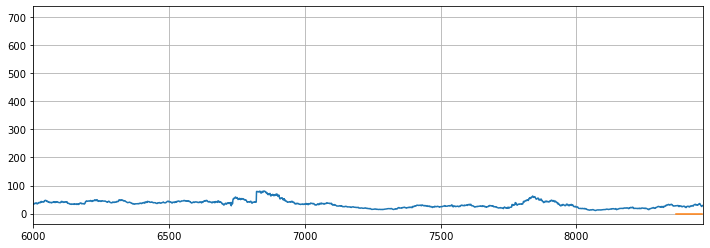

In [56]:
future = 100
# #prepare a lsit of predictions and append on this list
preds = train_minmax[-window_size:].tolist()

model.eval() 
for _ in range(future):
    #act as the current train
    seq = torch.FloatTensor(preds[-window_size:]).to(device)
    with torch.no_grad():
        yhat = model(seq)
        yhat = yhat.reshape(-1)
        preds.append(yhat.item()) 

print(len(preds[-window_size:]))

plt.figure(figsize=(12,4))
plt.xlim(6000,8466)
plt.grid(True)
plt.plot(y)
plt.plot(range(8365,8465),preds[window_size:])
plt.show()

## 10. Denormalize our data!

In [41]:
preds_real = scalar.inverse_transform(np.array(preds).reshape(-1,1))

In [42]:
preds_real[-window_size:]

array([[16.28221069],
       [16.28221069],
       [16.28221069],
       [16.28221069],
       [16.28221069],
       [16.28221069],
       [16.28221069],
       [16.28221069],
       [16.28221069],
       [16.28221069],
       [16.28221069],
       [16.28221069],
       [16.28221069],
       [16.28221069],
       [16.28221069],
       [16.28221069],
       [16.28221069],
       [16.28221069],
       [16.28221069],
       [16.28221069],
       [16.28221069],
       [16.28221069],
       [16.28221069],
       [16.28221069],
       [16.28221069],
       [16.28221069],
       [16.28221069],
       [16.28221069],
       [16.28221069],
       [16.28221069]])

In [43]:
test_set

array([15.13, 14.38, 14.25, 16.37, 16.5 , 16.88, 17.88, 17.75, 17.62,
       18.12, 18.5 , 19.  , 19.63, 19.87, 19.75, 19.75, 20.38, 20.62,
       21.75, 21.38, 20.13, 20.13, 19.13, 19.  , 19.37, 18.87, 20.13,
       21.62, 21.38, 21.62, 22.13, 22.87, 23.25, 24.  , 24.5 , 25.25,
       25.25, 25.87, 25.12, 24.75, 25.  , 24.62, 23.75, 24.12, 25.  ,
       24.  , 23.25, 22.63, 24.  , 24.12, 25.87, 25.  , 24.38, 23.75,
       22.75, 22.25, 24.12, 26.13, 25.12, 24.88, 25.75, 25.75, 26.  ,
       28.12, 29.13, 29.5 , 28.87, 29.63, 29.13, 30.25, 31.12, 31.25,
       31.75, 32.37, 32.5 , 32.87, 31.5 , 31.12, 30.5 , 31.62, 32.12,
       31.5 , 31.5 , 33.13, 33.13, 33.  , 33.  , 31.25, 31.38, 30.  ,
       28.38, 27.5 , 28.  , 27.5 , 26.87, 27.25, 27.38, 27.38, 28.  ,
       27.75, 27.38, 28.12, 28.25, 28.38, 28.38, 27.88, 28.25, 28.75,
       29.  , 29.25, 28.5 , 27.5 , 25.75, 25.  , 26.5 , 27.88, 27.88,
       27.88, 27.5 , 27.  , 25.75, 26.  , 26.5 , 26.37, 24.25, 24.5 ,
       24.75, 24.75,